4.394797300693788 3.872983346207417


<Figure size 432x288 with 0 Axes>

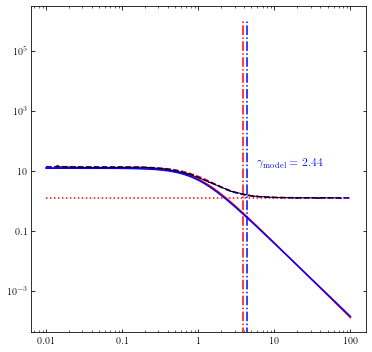

In [10]:
import streamlit as st
import pandas as pd
import numpy as np
import bokeh.plotting as bk
from scipy.integrate import cumtrapz
from bokeh.models import Range1d
import matplotlib.pyplot as plt
import emcee
from multiprocessing import Pool
from scipy.optimize import minimize

plt.clf()

gamma = 2.5 # st.sidebar.slider(r'Slope $\gamma$',2.01,max_value=5., value=2.5)
mu_max = norm = 2*np.pi/(gamma - 2)
background = 1e-1 * mu_max #10**st.sidebar.slider(r'$\log$ background',-3.,max_value=0., value=-1.) * mu_max
N = 10**5 # int(10**st.sidebar.slider(r'$\log$ N',min_value=1.,max_value=6., value=4.))
aperture = 100 #st.sidebar.slider(r'Aperture',0.,max_value=100., value=100.)

show_model = True #st.sidebar.checkbox("Show Model",True)
seed = 43 #st.sidebar.number_input("Seed",42)

#np.random.seed(seed)
r = np.logspace(-2,np.log10(aperture),1000)

Rmax = r.max()
cdf = 1 - (1 + r**2)**(1-gamma/2)
r50 = np.sqrt(2**(2/(gamma-2))-1) #np.interp(0.5,cdf,r)
sigma = norm * (1 + r**2)**(-gamma/2)
ecdf = cumtrapz(2*np.pi*r*(sigma + background), r,initial=0); ecdf_norm = ecdf.max()
fac =  np.trapz(r*sigma, r)/np.trapz(r*(sigma + background), r)
ecdf /= ecdf.max()
samples_within_r50 = 0
sample_size = N
while samples_within_r50 < N:
    samples = np.interp(np.sort(np.random.rand(sample_size)), ecdf, r)
    samples_within_r50 = (samples < 1).sum()
    sample_size *= 2
samples = samples[samples < aperture]

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.loglog(r, sigma,color='red',ls='solid',label="Ground-truth cluster")
ax.plot([r50,r50],[0,1e6],color='red',label=r"Ground-truth $R_{\rm eff}$",ls='dashdot')
ax.loglog(r,np.repeat(background,len(r)),label="Background",ls='dotted',color='red')
rbins = np.logspace(-2,min(2,np.log10(aperture)),15)
r_avg = (rbins[1:]*rbins[:-1])**0.5
N = np.histogram(samples,rbins)[0]
sigma_histogram = N/np.diff(np.pi*rbins**2) * ecdf_norm / len(samples)
sigma_histogram[sigma_histogram==0] = np.nan
ax.errorbar(r_avg[N>3],sigma_histogram[N>3],sigma_histogram[N>3]/np.sqrt(N[N>3]),label="Observed Counts",capsize=1,lw=1,color='black')
ax.loglog(r, sigma+background,label="Total",ls='dashed',color='red')

if show_model:
    # def lossfunc(x):
    #     return -log_prob(x)
    def lossfunc(x):
       logmu0, logbackground, loga, gam = x
       mu, background, a = 10**logmu0, 10**logbackground, 10**loga
       sigma_model = mu * (1+(r_avg/a)**2)**(-gam/2) + background
       mask = (~np.isnan(sigma_histogram))*(sigma_histogram>0)#*(r_avg>0.1)
#       N_model = sigma_model * np.diff(np.pi*rbins**2)
       return np.sum(np.log((sigma_model/sigma_histogram)[mask])**2 * N[mask])

    p0 = (np.log10(mu_max),np.log10(background), 0., gamma)
    sol = minimize(lossfunc, np.array(p0)+0.01,tol=1e-4)
    x = sol.x
    H = sol.hess_inv
    ax.loglog(r, 10**x[0] *  (1+(r/10**x[2])**2)**(-x[3]/2) + 10**x[1],label="Best-fit Model",color='blue',ls="dashed")
    sigma_model = 10**x[0] *  (1+(r/10**x[2])**2)**(-x[3]/2)
    ax.loglog(r, sigma_model,label="Best-fit Cluster Profile",color='blue',ls="solid")

    Reff_model = 10**x[2]*(2**(2/(x[3]-2)) - 1 )**0.5
    print(Reff_model,r50)
   # st.write(r"$\gamma=%g$"%x[3])
    ax.text(6,15,r"$\gamma_{\rm model}=%4.3g$"%(x[3]),fontsize=12,color="blue")

    if np.isnan(Reff_model):
        ax.text(1e1,1e1,r"$R_{\rm eff}$ undefined!",fontsize=12)
    ax.plot([Reff_model,Reff_model],[0,1e6],color='blue',label=r"Model $R_{\rm eff}$",ls='dashdot')

In [129]:

def prior(x):
    mu0, background, a, gamma = x
    if gamma < 2 or gamma > 10: return -np.inf
    if mu0 < -100 or mu0 > 100: return -np.inf
    if background < -100 or background > 100: return -np.inf
    if a < -100 or a > 100: return -np.inf
    return 1.

def log_prob(x):
    logmu0, logbackground, loga, g = x
    mu, background, a = 10**logmu0, 10**logbackground, 10**loga
    norm = (background*Rmax**2)/2. + (mu*(a**2 - a**g*(a**2 + Rmax**2)**(1 - g/2.)))/(g - 2)
    lnprob = samples * (mu*(1 + np.square(samples/a))**(-g/2) + background) / norm
    lnprob = np.log(lnprob)
    lnprob = np.sum(lnprob) + prior(x)
    if np.isnan(lnprob): lnprob = -np.inf
    return lnprob


ndim, nwalkers = 4, 100
p0 = np.array([np.log10(mu_max),np.log10(background),0,2.5]) + 1e-2*np.random.normal(size=(nwalkers,ndim))

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)#,pool=pool)
    sampler.run_mcmc(p0, 1000,progress=True)
s = sampler.get_chain(flat = True,discard=100,thin=50)


  6%|▌         | 60/1000 [00:52<13:58,  1.12it/s]Traceback (most recent call last):
  File "/Users/mgrudic/opt/anaconda3/lib/python3.8/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-129-0a4a4ca6e77a>", line 13, in log_prob
    lnprob = samples * (mu*(1 + np.square(samples/a))**(-g/2) + background) / norm
KeyboardInterrupt
  6%|▌         | 60/1000 [00:52<13:43,  1.14it/s]

emcee: Exception while calling your likelihood function:
  params: [ 1.30483633  0.30643793 -0.00592113  2.46167942]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [120]:
logReff_sample = np.log10(10**s[:,2]*(2**(2/(s[:,-1]-2))-1)**0.5)
#Reff_sample
#10**np.median(Reff_sample), r50
#samples[:,-1].min()
#plt.hist(10**logReff_sample,100); plt.yscale('log')
np.percentile(10**logReff_sample,[16,50,84]), np.log10(r50)
#minimize(lambda x: -log_prob(x),p0[0])
#plt.hist(s[:,-1])
#np
#s

(array([ 3.42976766,  5.36510286, 13.11644227]), 0.5880456295278407)

In [119]:
np.percentile(s[:,-1],[16,50,84]), H[-1,-1]**0.5



(array([2.25531062, 2.39291975, 2.5472394 ]), 0.10686175727304958)

In [117]:
s[

array([10.55280503,  9.50228754, -0.07175505,  2.31045309])

(array([5.160e+02, 3.264e+03, 3.006e+03, 4.210e+02, 3.100e+01, 3.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 2.73069513,  4.00570297,  5.28071081,  6.55571864,  7.83072648,
         9.10573432, 10.38074216, 11.65575   , 12.93075784, 14.20576567,
        15.48077351]),
 <BarContainer object of 10 artists>)

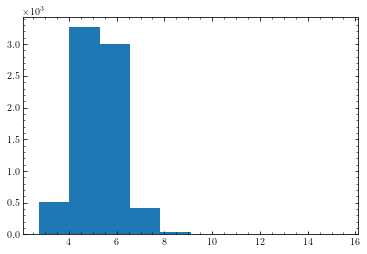

In [127]:
from astropy.table import Table
catalog = Table.read("cluster_sizes_brown_gnedin_21.txt", format="ascii.ecsv")
#plt.hist(np.log10(catalog["mu_0"] * np.pi * catalog["scale_radius_pixels"]**2))

In [12]:
%lprun -f lossfunc lossfunc(x)

Timer unit: 1e-06 s

Total time: 0.000144 s
File: <ipython-input-10-fbfedf1065eb>
Function: lossfunc at line 56

Line #      Hits         Time  Per Hit   % Time  Line Contents
    56                                               def lossfunc(x):
    57         1         10.0     10.0      6.9         logmu0, logbackground, loga, gam = x
    58         1          8.0      8.0      5.6         mu, background, a = 10**logmu0, 10**logbackground, 10**loga
    59         1         47.0     47.0     32.6         sigma_model = mu * (1+(r_avg/a)**2)**(-gam/2) + background
    60         1         13.0     13.0      9.0         mask = (~np.isnan(sigma_histogram))*(sigma_histogram>0)#*(r_avg>0.1)
    61                                           #       N_model = sigma_model * np.diff(np.pi*rbins**2)
    62         1         66.0     66.0     45.8         return np.sum(np.log((sigma_model/sigma_histogram)[mask])**2 * N[mask])

In [5]:
from numba import njit

In [6]:
lossfunc = njit(lossfunc,parallel=True)